In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import SimpleITK as sitk

from google.colab.patches import cv2_imshow

import ipywidgets as widgets
from ipywidgets import interact, interact_manual


def imshow(img):
  return cv2_imshow(img)

In [ ]:
def normalize_intensity(image, scale_min=0, scale_max=1):
    # Calculate the minimum and maximum of the image
    img_min = np.min(image)
    img_max = np.max(image)

    # Normalize the image
    normalized_image = (image - img_min) / (img_max - img_min) * (scale_max - scale_min) + scale_min

    return normalized_image

# Get paths for subsets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir(os.path.join(os.getcwd(), "drive", "Shareddrives", "IA DL_project", "ML IA"))

['nb_Aron',
 'ML IP_proposal.gdoc',
 'LUNA16',
 'sources',
 'nb_Souparno',
 'Lung Nodule Analysis.gdoc',
 'nb_Karim',
 'crazy image',
 'nb_Seabass']

In [ ]:
path = os.path.join(os.getcwd(), "drive", "Shareddrives", "IA DL_project", "ML IA", "LUNA16")

path_subsets = os.path.join(path, "subsets") # path for subsets folder
subsets = os.listdir(path_subsets) # subset folders present

# Create empty dictionary for cases

In [ ]:
subset_dict =  {}
meta_dict =  {}

subset_path = lambda subset: os.path.join(path_subsets, subset)
file_path = lambda subset, filename: os.path.join(path_subsets, subset, filename)

for i, subset in enumerate(subsets):
  subset_dict[subset] = {}
  meta_dict[subset] = {}

  for j, filename in enumerate(os.listdir(subset_path(subset))):
    split = os.path.splitext(filename)
    if split[1] == ".mhd":
      subset_dict[subset][split[0]] = None
      meta_dict[subset][split[0]] = None



print(f"Subset keys: {list(subset_dict.keys())}")
print(f"Subset lengths: {[len(subset_dict[key]) for key in subset_dict.keys()]}")

Subset keys: ['subset0', 'subset1']
Subset lengths: [89, 89]


# Loading MetaImages (mhd/raw)

In [ ]:
def read_mhd_image(file_path: str) -> np.ndarray:
    if not file_path.endswith(".mhd"):
      file_path += ".mhd"
    # Load the image using SimpleITK
    image = sitk.ReadImage(file_path)

    # Convert the SimpleITK image to a numpy array if needed
    image_array = sitk.GetArrayFromImage(image)
    spacing = image.GetSpacing()
    origin = image.GetOrigin()

    return image_array, (origin, spacing)

## Single image example

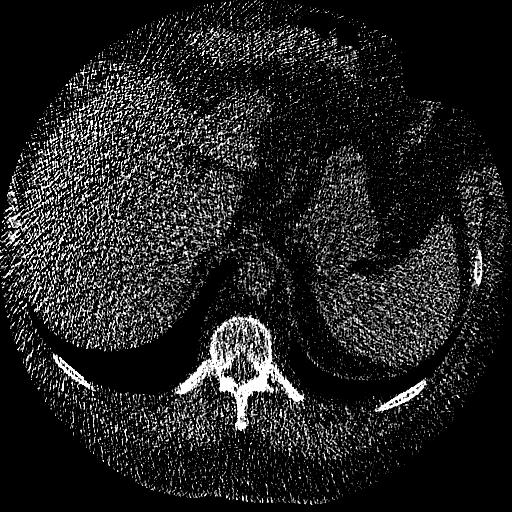

CT image size: (545, 512, 512)
CT image min I: -3024
CT image max I: 1706
CT image unique values I: [-3024 -1024 -1023 ...  1671  1690  1706]


In [ ]:
subset_keys = list(subset_dict.keys())
filename_keys = [list(subset_dict[key].keys()) for key in subset_keys]

subset_index = 0
filename_index = 71

img, meta = read_mhd_image(file_path(subset_keys[subset_index], filename_keys[subset_index][filename_index]))

subset_dict[subset_keys[subset_index]][filename_keys[subset_index][filename_index]] = img.copy()
meta_dict[subset_keys[subset_index]][filename_keys[subset_index][filename_index]] = {"origin": meta[0], "spacing": meta[1]}

z_slice_index = 100

imshow(img[z_slice_index,:,:])
print(f"CT image size: {img.shape}")
print(f"CT image min I: {img.min()}")
print(f"CT image max I: {img.max()}")
print(f"CT image unique values I: {np.unique(img)}")


### RAW

#### Slice thorugh the Z axis

In [ ]:
slices = img.shape[0]
print(img.shape[1::])
@interact
def show_slice(slice_index=(0,slices-1,1)):
  imshow(img[slice_index,:,:])

(512, 512)


interactive(children=(IntSlider(value=272, description='slice_index', max=544), Output()), _dom_classes=('widg…

#### Slices along the X axis

In [ ]:
slices = img.shape[1]
print(img.shape[::2])
@interact
def show_slice(slice_index=(0,slices-1,1)):
  imshow(img[:,slice_index,:])

(545, 512)


interactive(children=(IntSlider(value=255, description='slice_index', max=511), Output()), _dom_classes=('widg…

#### Slices along the Y axis

In [ ]:
slices = img.shape[2]
print(img.shape[:2:])

@interact
def show_slice(slice_index=(0,slices,1)):
  imshow(img[:,:,slice_index,])

(545, 512)


interactive(children=(IntSlider(value=256, description='slice_index', max=512), Output()), _dom_classes=('widg…

### Threshold according to Hounsfield Units (HU)

# NOTE: Deprecated (old) one

In [ ]:
from skimage.segmentation import clear_border
from scipy.ndimage import binary_fill_holes, binary_closing
from skimage import measure, morphology
from skimage.segmentation import clear_border


def unwanted_object_filter(img: np.ndarray) -> np.ndarray:

  closed = binary_closing(img, morphology.disk((3)))

  # Label connected components
  labels = measure.label(closed)
  properties = measure.regionprops(labels)

  # Sort regions by area and keep the two largest
  detected_objects = sorted(properties, key=lambda x: x.area, reverse=True)

  # Case when more than 4 detected object
  if len(detected_objects) >= 4:
    detected_objects = detected_objects[:4]

    # 4th largest object is significantly smaller then the 3rd
    if detected_objects[2].area * 0.5 > (detected_objects[3].area):
        detected_objects = detected_objects[:3]

    # 3rd largest object is significantly smaller then the 2nd
    if detected_objects[1].area * 0.1 > (detected_objects[2].area):
      detected_objects = detected_objects[:2]

  # Case when there is only 3 detected objects
  elif len(detected_objects) == 3:
    # 3rd largest object is significantly smaller then the 2nd
    if detected_objects[1].area * 0.1 > (detected_objects[2].area):
      detected_objects = detected_objects[:2]

  # Create an empty image to hold the result
  filtered_image = np.zeros_like(img, dtype=np.uint8)

  # Fill in the regions of the two largest objects
  for prop in detected_objects:
      filtered_image[labels == prop.label] = 255

  return filtered_image


def closing(img):
  closed = binary_closing(img, morphology.disk((3)), 3) # apply closing 3 times
  holeless = binary_fill_holes(closed) # fill the remaining holes
  return holeless.astype(np.uint8) * 255 # return an unsigned 8-bit mask


lung_th = -500

def binarize_img(img: np.ndarray, threshold_val = lung_th):
  """
  Extraction function for lung ROI (2D and 3D)

  - thresholding using HU for air filled organs
  - clearing info outside of the subject body
  - dilation and filling of the ROI (lung area)
  """

  # 3D
  if len(img.shape) == 3:
    bin = (img[:,:,:] < threshold_val) # thresholding

    th = bin.astype(np.uint8) * 255 # normalizing to 0 and 255 values (unsigned 8-bit int) !NOTE!: this might be an unneded line

    th = np.vectorize(clear_border, signature="(n,m)->(n,m)")(th) # remove border

    th = np.vectorize(unwanted_object_filter, signature="(n,m)->(n,m)")(th) # remove small objects

    th = np.vectorize(closing, signature="(n,m)->(n,m)")(th) # remove small holes and edge smoothing

  # 2D
  elif len(img.shape) == 2:
    bin = (img[:,:] < threshold_val) # thresholding

    th = bin.astype(np.uint8) * 255 # normalizing to 0 and 255 values (unsigned 8-bit int) !NOTE!: this might be an unneded line

    th = clear_border(th) # remove border

    th = unwanted_object_filter(th) # remove small objects

    th = closing(th) # remove small holes and edge smoothing

  return th


# NEW FUNCTION

In [ ]:
from skimage.segmentation import clear_border
from scipy.ndimage import binary_fill_holes, binary_closing, binary_dilation, binary_opening, binary_erosion
from skimage import measure, morphology
from skimage.segmentation import clear_border
from scipy.ndimage import median_filter

def unwanted_object_filter(img: np.ndarray) -> np.ndarray:
  closed = binary_closing(img, morphology.disk((3)))

  # Label connected components
  labels = measure.label(closed)
  properties = measure.regionprops(labels)

  # Sort regions by area and keep the two largest
  detected_objects = sorted(properties, key=lambda x: x.area, reverse=True)

  # Filter out the relevant sizes
  area_th = 50
  detected_objects = [obj for obj in detected_objects if obj.area > area_th]

  # Case when more than 4 detected object
  if len(detected_objects) >= 4:
    detected_objects = detected_objects[:4]

    # 4th largest object is significantly smaller then the 3rd
    if detected_objects[2].area * 0.1 > (detected_objects[3].area):
        detected_objects = detected_objects[:3]

    # 3rd largest object is significantly smaller then the 2nd
    if detected_objects[1].area * 0.5 > (detected_objects[2].area):
      detected_objects = detected_objects[:2]

  # Case when there is only 3 detected objects
  elif len(detected_objects) == 3:
    # 3rd largest object is significantly smaller then the 2nd
    if detected_objects[1].area * 0.1 > (detected_objects[2].area):
      detected_objects = detected_objects[:2]

  # Create an empty image to hold the result
  filtered_image = np.zeros_like(img, dtype=np.uint8)

  # Fill in the regions of the two largest objects
  for prop in detected_objects:
      filtered_image[labels == prop.label] = 255

  return filtered_image


def closing(img):
  return binary_closing(img, morphology.disk((5)))

def dilate(img):
  return binary_dilation(img, morphology.disk((3)))

def erosion(img):
  return binary_erosion(img, morphology.disk((3)))

def opening(img):
  return binary_opening(img, morphology.disk((3)))

def median_blur(img, ksize=5):
  return cv.medianBlur(img, ksize=ksize)


air_th = -1000 # HU th specified by findings in the sources
lung_th = -500 # HU th specified by findings in the sources

def lung_mask(img: np.ndarray, verbose=True):
  """
  Extraction function for lung ROI (2D and 3D)

  - thresholding using HU for air filled organs
  - clearing info outside of the subject body
  - dilation and filling of the ROI (lung area)
  """

  # 3D
  if len(img.shape) == 3:
    # Denoising
    if verbose:
      print(f"[PROC] - DENOISING")
    denoised = np.vectorize(median_blur, signature="(n,m)->(n,m)")(img)

    # Thresholding
    if verbose:
      print(f"[PROC] - THRESHOLDNG")
    bin = denoised <= lung_th
    th = bin.astype(np.uint8) * 255 # normalizing to 0 and 255 values (unsigned 8-bit int) !NOTE!: this might be an unneded line

    if verbose:
      print(f"[PROC] - CLEARING BORDER ON Z-AXIS")
    th = np.vectorize(clear_border, signature="(n,m)->(n,m)")(th) # remove border

    if verbose:
      print(f"[PROC] - OBJECT FILTERING ON Z-AXIS")
    th = np.vectorize(unwanted_object_filter, signature="(n,m)->(n,m)")(th) # remove small objects

    # th = np.vectorize(closing, signature="(n,m)->(n,m)")(th) # remove small holes and edge smoothing

    for i in range(2):

      if verbose:
        print(f"[PROC] - FILLING HOLES on AXIS-{i}")
      th = process_slices(th, i, binary_fill_holes)


      if verbose:
        print(f"[PROC] - CLOSING on AXIS-{i}")
      th = process_slices(th, i, closing)




  # 2D NOTE: WIP
  elif len(img.shape) == 2:
    #bin = (denoised <= lung_th) # (denoised >= air_th) # thresholding

    #th = bin.astype(np.uint8) * 255 # normalizing to 0 and 255 values (unsigned 8-bit int) !NOTE!: this might be an unneded line

    #th = clear_border(th) # remove border

    #th = unwanted_object_filter(th) # remove small objects

    #th = closing(th) # remove small holes and edge smoothing

    # th = dilate(th) # remove small objects for smoothing
    pass
  return th

def lung_mask_by_uid(uid):
  return lung_mask(img_by_uid(uid),)

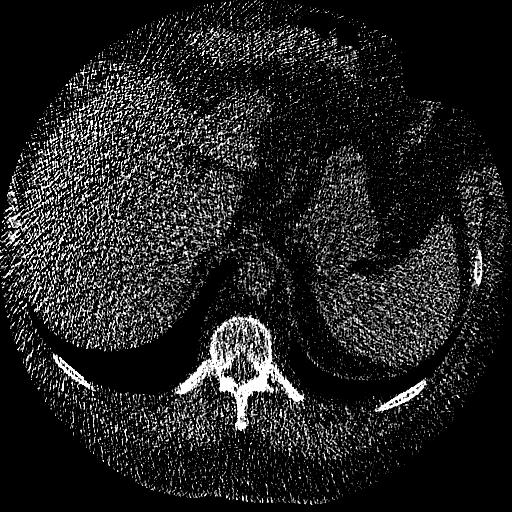

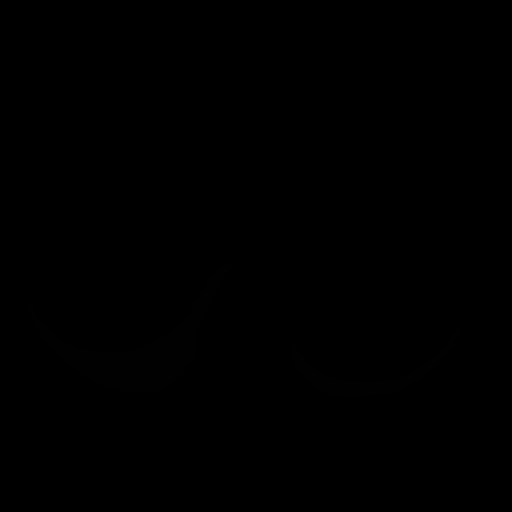

Thresholded CT image size: (545, 512, 512)
Thresholded CT image min I: False
Thresholded CT image max I: True
Thresholded CT unique I values: [False  True]


In [ ]:
th = binarize_img(img)

z_slice_index = 100
imshow((img[z_slice_index,:,:]))
imshow(th[z_slice_index,:,:])

print(f"Thresholded CT image size: {th.shape}")
print(f"Thresholded CT image min I: {th.min()}")
print(f"Thresholded CT image max I: {th.max()}")
print(f"Thresholded CT unique I values: {np.unique(th)}")

#### SLices along Z axis

In [ ]:
slices = th.shape[0]
print(th.shape[1::])
@interact
def show_slice(slice_index=(0,slices-1,1)):
  og, mask = normalize_intensity(img[slice_index,:,:], 0, 255), th[slice_index,:,:]
  imshow(og)
  imshow(mask)
  imshow(normalize_intensity(og*mask.astype(bool), 0, 255))


#### Slices along X axis


In [ ]:
slices = th.shape[1]
print(th.shape[::2])
@interact
def show_slice(slice_index=(0,slices-1,1)):
  og, mask = normalize_intensity(img[:,slice_index,:], 0, 255), th[:,slice_index,:]
  imshow(og)
  imshow(mask)
  imshow(normalize_intensity(og*mask.astype(bool), 0, 255))

#### Slices along Y axis

In [ ]:
slices = th.shape[2]
print(th.shape[:2:])

@interact
def show_slice(slice_index=(0,slices-1,1)):
  og, mask = normalize_intensity(img[:,:,slice_index], 0, 255), th[:,:,slice_index]
  imshow(og)
  imshow(mask)
  imshow(normalize_intensity(og*mask.astype(bool), 0, 255))

# Load all images for ONE subset

In [ ]:
subset_keys = list(subset_dict.keys())
filename_keys = [list(subset_dict[key].keys()) for key in subset_keys]

# SECURITY LOCK in case I accidentally ran the cell (too much time and memory)
run = False
load_num = 10

if run:
  subset_index = 0


  for i, filename in enumerate(filename_keys[subset_index]):
    print(f"Image #{i+1} out of {len(filename_keys[subset_index])}")

    if subset_dict[subset_keys[subset_index]][filename] is None:
      img, meta = read_mhd_image(file_path(subset_keys[subset_index], filename))
      subset_dict[subset_keys[subset_index]][filename] = img
      meta_dict[subset_keys[subset_index]][filename] = {"origin": meta[0], "spacing": meta[1]}


    if i == load_num: break

  subset_dict

# Create annotations

In [ ]:
subset_keys = list(subset_dict.keys())
filename_keys = [list(subset_dict[key].keys()) for key in subset_keys]

# Function to find the index of the sub-array containing the id
def find_index(id_value, nested_list):
    for index, sublist in enumerate(nested_list):
        if id_value in sublist:
            return subset_keys[index]
    return None  # or return a default value if the id is not found

filtered_df['subset_i'] = filtered_df['seriesuid'].apply(lambda x: find_index(x, filename_keys))
filtered_df

In [ ]:
origins = []
spacings = []
for i, row in filtered_df.iterrows():
  metas = meta_dict[row["subset_i"]][row["seriesuid"]]
  print(metas)
  if metas is not None:
    origins.append(metas["origin"])
    spacings.append(metas["spacing"])

In [ ]:
subset_keys = list(subset_dict.keys())
filename_keys = [list(subset_dict[key].keys()) for key in subset_keys]

annotation_dict = {key: {f"{fn_key}": [] for j, fn_key in enumerate(filename_keys[i])}  for i, key in enumerate(subset_keys)}

In [ ]:
for ss_key, ss_val in meta_dict.items():
  for fn_key, fn_val in ss_val.items():
    print(f"{fn_key}: {fn_val}")

__________________________